In [1]:
parameters = {
    "D": 150,
    "t": 4.3,
    "L": 450,
    "Es": 209720,
    "fc": 18,
    "Ec": 0,
    "fy": 279,
    "fu": 0,
}

In [2]:
import math
import pandas as pd
import matplotlib.pyplot as plt

In [29]:
class CFST:
    def __init__(self, parameters) -> dict:
        self.input_parameters = parameters
        self.general_parameters = {}
        self.steel_tube_parameters = {}
        self.concrete_parameters = {}
        self.csft_df = pd.DataFrame()

    def __calculate_general_parameters(self):
        D = self.input_parameters["D"]
        t = self.input_parameters["t"]
        L = self.input_parameters["L"]
        Es = self.input_parameters["Es"]
        fc = self.input_parameters["fc"]
        Ec = self.input_parameters["Ec"]
        fy = self.input_parameters["fy"]
        fu = self.input_parameters["fu"]

        # Outer diameter/thickness ratio
        outer_diameter_thickness_ratio = D / t
        self.general_parameters["outer_diameter_thickness_ratio"] = (
            outer_diameter_thickness_ratio
        )

        # Length/outer diameter ratio
        length_outer_diameter_ratio = L / D
        self.general_parameters["length_outer_diameter_ratio"] = (
            length_outer_diameter_ratio
        )

        # Cross section area of core concrete
        A_cc = math.pi * (D - 2 * t) ** 2 / 4
        self.general_parameters["A_cc"] = A_cc

        # Total cross section area of column
        A_total = math.pi * D**2 / 4
        self.general_parameters["A_total"] = A_total

        # Cross section area of steel
        A_s = A_total - A_cc
        self.general_parameters["A_s"] = A_s

        # Confinement factor
        CF = (A_s * fy) / (fc * A_cc)
        self.general_parameters["confinement_factor"] = CF

    def __calculate_steel_tube_parameters(self):
        A_s = self.general_parameters["A_s"]
        A_total = self.general_parameters["A_total"]
        A_cc = self.general_parameters["A_cc"]

        input_parameters = self.input_parameters
        Es = input_parameters["Es"]
        fy = input_parameters["fy"]
        fu = input_parameters["fu"]
        fc = input_parameters["fc"]
        epsilon_c0 = input_parameters.get(
            "epsilon_c0", 0
        )  # Default value for epsilon_c0
        Ec = input_parameters["Ec"]
        CF = (A_s * fy) / (fc * A_cc)

        # Calculate Initial Modulus of Elasticity (Ep)
        Ep = 0.02 * input_parameters["Es"]

        if input_parameters["Ec"] == 0:
            Ec = 4700 * math.sqrt(fc)  # Calculating Ec based on the provided formula
        else:
            Ec = input_parameters["Ec"]

        # Calculate Normal Strain of Steel
        epsilon_y = fy / Es

        # Calculate Strain at Peak Stress (epsilon_c0)
        epsilon_c0 = 0.002 * (1 + A_s / A_total * Es / Ec)

        # Calculate First Peak Stress (fy_prime)
        expression = 1.02 - 0.01 * ((epsilon_y / epsilon_c0) ** 1.5) * (
            (input_parameters["D"] / input_parameters["t"]) ** 0.5
        )

        if expression < 0:
            fy_prime = 0.001 * fy
        elif expression > 1:
            fy_prime = fy
        else:
            fy_prime = expression * fy

        # Calculate Strain Corresponding to First Peak Stress (ey_prime)
        epsilony_prime = fy_prime / Es

        # Calculate Critical Stress (fcr_prime)
        if (
            fy_prime * (math.exp(-0.39 + 0.1 * CF + 0.06 * math.log(CF) / (CF**2)))
            >= fy_prime
        ):
            fcr_prime = fy_prime
        else:
            fcr_prime = fy_prime * (
                math.exp(-0.39 + 0.1 * CF + 0.06 * math.log(CF) / (CF**2))
            )

        # Calculate Ultimate Strain (eu)
        if fy <= 300:
            eu = 100 * fy / Es
        elif fy <= 800:
            eu = 100 - (0.15 * (fy - 300) * (fy / Es))
        else:
            eu = 25 - (0.1 * (fy - 800) * fy / Es)

        # Calculate Critical Strain (ecr_prime)
        ey = epsilon_y
        t_D_fc = input_parameters["t"] / (
            input_parameters["D"] * input_parameters["fc"]
        )
        expression_ecr = ey * (
            28 - (0.07 * CF) - (12 / (CF**0.2)) - (0.13 * (fy**0.75) * (t_D_fc**0.07))
        )

        if expression_ecr < ey:
            ecr_prime = ey
        elif expression_ecr > eu:
            ecr_prime = eu
        else:
            ecr_prime = expression_ecr

        # Calculate Ultimate Stress of Steel (fu)
        if fu == 0:
            if fy <= 400:
                fu = (1.6 - (0.002 * (fy - 200))) * fy
            elif fy <= 800:
                fu = (1.2 - (0.000375 * (fy - 400))) * fy
            elif fy <= 960:
                fu = 1.05 * fy

        # Calculate Stress (fu_prime)
        expression_fu_prime = fy * (
            6.8
            - (0.013 * CF)
            - (3.5 / (CF**0.15))
            - ((1.3 * (fy**0.25)) * (t_D_fc**0.15))
        )

        if expression_fu_prime <= fcr_prime:
            fu_prime = fcr_prime + (1 / 1000)
        elif expression_fu_prime > fu:
            fu_prime = fu
        else:
            fu_prime = expression_fu_prime

        # Calculate Strain Softening Exponent (psi)
        psi = 1.5  # Constant value for psi

        # Calculate Strain Hardening Exponent (p)
        p = Ep * ((eu - ecr_prime) / (fu_prime - fcr_prime))

        # Output dictionary with labels
        self.steel_tube_parameters = {
            "Modulus of Elasticity of Steel": Es,
            "Strain Corresponding to First Peak Stress": epsilony_prime,
            "First Peak Stress": fy_prime,
            "Critical Stress": fcr_prime,
            "Ultimate Strain": eu,
            "Critical Strain": ecr_prime,
            "Ultimate Stress of Steel": fu,
            "Stress": fu_prime,
            "Initial Modulus of Elasticity": Ep,
            "Strain Hardening Exponent": p,
            "Strain at Peak Stress": epsilon_c0,
            "Strain Softening Exponent": psi,
        }

    def __calculate_concrete_parameters(self):
        # general parameters
        A_cc = self.general_parameters["A_cc"]
        A_s = self.general_parameters["A_s"]

        # steel parameter
        eu = self.steel_tube_parameters["Ultimate Strain"]

        # input parameters
        input_parameters = self.input_parameters
        fc = input_parameters["fc"]
        D = input_parameters["D"]
        t = input_parameters["t"]
        fy = input_parameters["fy"]

        if input_parameters["Ec"] == 0:
            Ec = 4700 * math.sqrt(fc)  # Calculating Ec based on the provided formula
        else:
            Ec = input_parameters["Ec"]

        CF = (A_s * fy) / (fc * A_cc)

        ratio1 = (input_parameters["fy"] / fc) ** 0.696
        ratio2 = (D / t) ** 0.46

        if (1 + 0.2 * ratio1 + (0.9 - 0.25 * ratio2) * math.sqrt(CF)) < 1:
            fcc_prime = fc
        elif (1 + 0.2 * ratio1 + (0.9 - 0.25 * ratio2) * math.sqrt(CF)) > 3:
            fcc_prime = 3 * fc
        else:
            fcc_prime = (1 + 0.2 * ratio1 + (0.9 - 0.25 * ratio2) * math.sqrt(CF)) * fc

        # Check condition for epsilon_cc_prime
        condition_value = (
            3000
            - (
                10.4
                * (input_parameters["fy"] ** 1.4)
                * (fcc_prime**-1.2)
                * (0.73 - 3785.8 * ((D / t) ** -1.5))
            )
            / 1000000
        )
        if condition_value < fcc_prime:
            epsilon_cc_prime = condition_value
        else:
            epsilon_cc_prime = fcc_prime

        A = (
            1 + (0.25 * (CF ** (0.05 + (0.25 / CF))) * (epsilon_cc_prime * Ec))
        ) / fcc_prime

        expression_B = 2.15 - (2.05 * math.exp(-CF)) - (0.0076 * fc)
        if expression_B < -0.075:
            B = -0.75
        else:
            B = expression_B

        expression = fcc_prime * (
            3.5 * ((input_parameters["t"] / (input_parameters["D"] * (fc**0.7))) ** 0.2)
            - (0.2 / (CF**0.3))
        )
        if expression >= fcc_prime:
            fr = fcc_prime
        else:
            fr = expression

        self.concrete_parameters = {
            "Ec": Ec,
            "fcc_prime": fcc_prime,
            "epsilon_cc_prime": epsilon_cc_prime,
            "fr": fr,
            "eu": eu,
            "A": A,
            "B": B,
        }

    def __calculate_steel_stress(self, strain):
        steel_params = self.steel_tube_parameters

        # Obtain values from steel_params dictionary
        epsilony_prime = steel_params["Strain Corresponding to First Peak Stress"]
        Es = steel_params["Modulus of Elasticity of Steel"]
        fy_prime = steel_params["First Peak Stress"]
        fcr_prime = steel_params["Critical Stress"]
        psi = steel_params["Strain Softening Exponent"]
        eu = steel_params["Ultimate Strain"]
        fu_prime = steel_params["Ultimate Stress of Steel"]
        ecr_prime = steel_params["Critical Strain"]
        p = steel_params["Strain Hardening Exponent"]

        # Calculate stress based on given conditions
        if self.general_parameters["length_outer_diameter_ratio"] > 5:
            return 0
        elif strain < epsilony_prime:
            return Es * strain
        elif epsilony_prime <= strain <= ecr_prime:
            return (
                fcr_prime
                - (fcr_prime - fy_prime)
                * ((ecr_prime - strain) / (ecr_prime - epsilony_prime)) ** psi
            )
        elif ecr_prime < strain <= eu:
            return (
                fu_prime
                - (fu_prime - fcr_prime) * ((eu - strain) / (eu - ecr_prime)) ** p
            )
        elif strain > eu:
            return fu_prime

    def __calculate_concrete_stress(self, strain):

        fr = self.concrete_parameters["fr"]
        fcc_prime = self.concrete_parameters["fcc_prime"]
        epsilon_cc_prime = self.concrete_parameters["epsilon_cc_prime"]
        A = self.concrete_parameters["A"]
        B = self.concrete_parameters["B"]

        X = strain / epsilon_cc_prime

        if self.general_parameters["length_outer_diameter_ratio"] > 5:
            Y = 0
        else:
            Y = ((A * X) + (B * X**2)) / (1 + ((A - 2) * X) + ((B + 1) * X**2))
        if X > 1 and Y < (fr / fcc_prime):
            return fr
        else:
            return Y * fr

    def perform_caculations(self):

        ## calculating all required parameters
        self.__calculate_general_parameters()
        self.__calculate_steel_tube_parameters()
        self.__calculate_concrete_parameters()

        ## reading the strain values as pandas dataframe
        csft_df = pd.read_csv("strain_value.csv")

        ## calculating the steel stress
        csft_df["steel_stress"] = csft_df["strain"].apply(
            lambda strain: self.__calculate_steel_stress(strain=strain)
        )

        ## calculating the concrete stress
        csft_df["concrete_stress"] = csft_df["strain"].apply(
            lambda strain: self.__calculate_concrete_stress(strain=strain)
        )

        ## calculating steel load capacity
        csft_df["steel_load_capacity"] = csft_df["steel_stress"].apply(
            lambda steel_stress: steel_stress * self.general_parameters["A_s"] / 1000
        )

        ## calculating concrete load capacity
        csft_df["concrete_load_capacity"] = csft_df["concrete_stress"].apply(
            lambda concrete_stress: concrete_stress
            * self.general_parameters["A_cc"]
            / 1000
        )

        ## calculating total load capacity
        csft_df['total_load_capacity'] = csft_df['steel_load_capacity'] + csft_df['concrete_load_capacity']

        self.csft_df = csft_df

    def get_csft_data(self):
        return self.csft_df
    
    def plot_graph(self, target_value):
        # Create a figure and axis object
        fig, ax1 = plt.subplots(figsize=(10, 8))

        # Plot the line chart
        ax1.plot(self.csft_df['strain'], self.csft_df[target_value], color='blue', label='Y')
        ax1.set_xlabel('strain')
        ax1.set_ylabel(target_value, color='blue')
        ax1.tick_params(axis='y', labelcolor='blue') 
        ax1.grid(True)

        # Set title and legend
        ax1.set_title(f'strain vs {target_value}')

        # Show the plot
        plt.tight_layout()
        plt.show()

In [30]:
obj = CFST(parameters=parameters)

In [31]:
obj.perform_caculations()

In [32]:
pd.set_option("display.max_rows", None)

In [33]:
df = obj.get_csft_data()
df

,strain,steel_stress,concrete_stress,steel_load_capacity,concrete_load_capacity,total_load_capacity
0,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.0002,41.944000,1.067770,82.555826,16.767425,99.323251
2,0.0003,62.916000,1.575513,123.833738,24.740619,148.574358
3,0.0005,104.860000,2.542845,206.389564,39.930856,246.320420
4,0.0007,146.804000,3.450893,288.945389,54.190129,343.135518
5,0.0008,167.776000,3.884362,330.223302,60.996995,391.220298
6,0.0010,209.720000,4.713203,412.779128,74.012468,486.791596
7,0.0012,251.664000,5.494862,495.334953,86.287023,581.621976
8,0.0013,272.636000,5.869239,536.612866,92.165949,628.778815
9,0.0015,278.159667,6.587335,547.484763,103.442361,650.927124


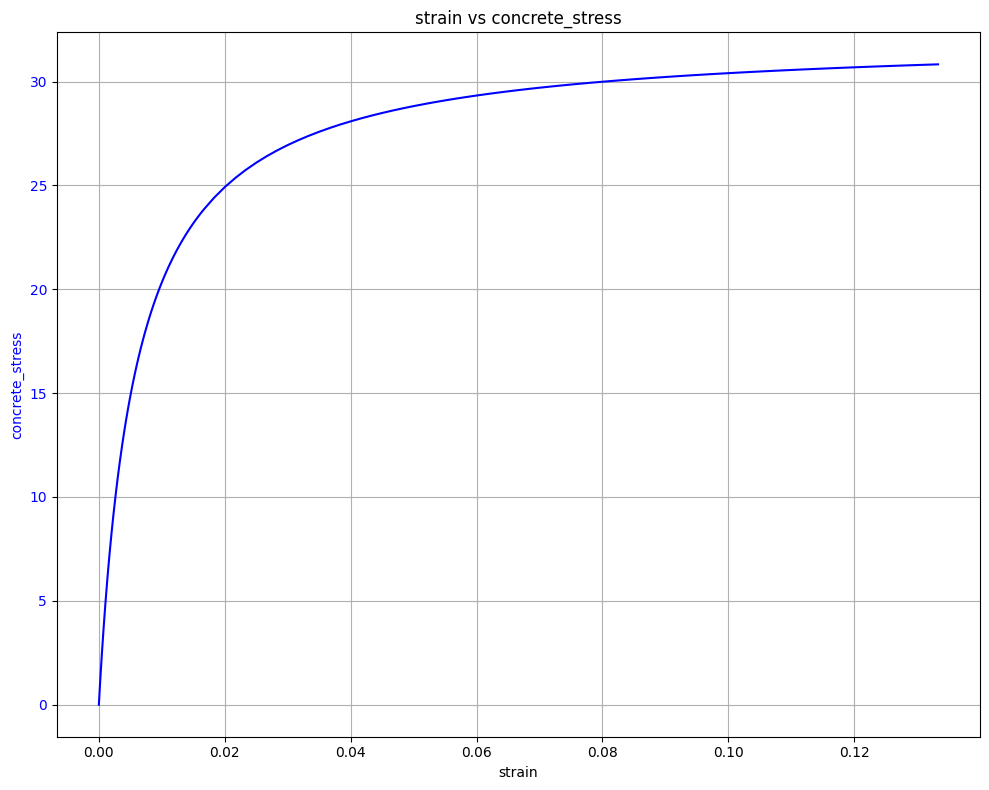

In [34]:
obj.plot_graph("concrete_stress")

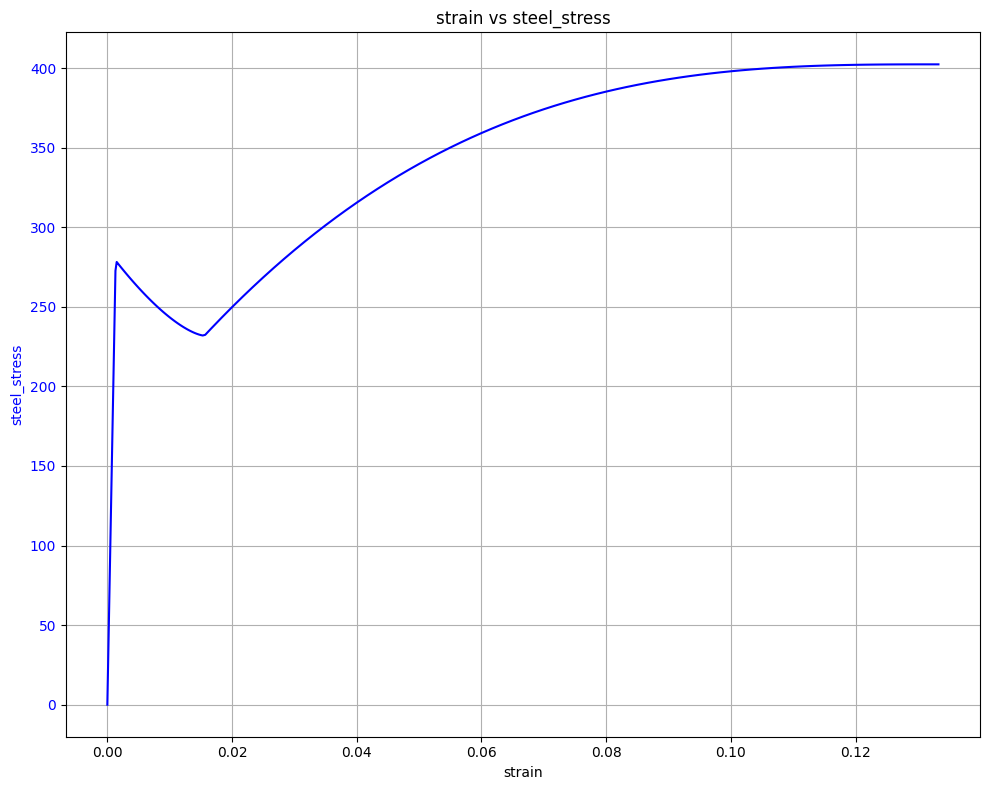

In [35]:
obj.plot_graph("steel_stress")

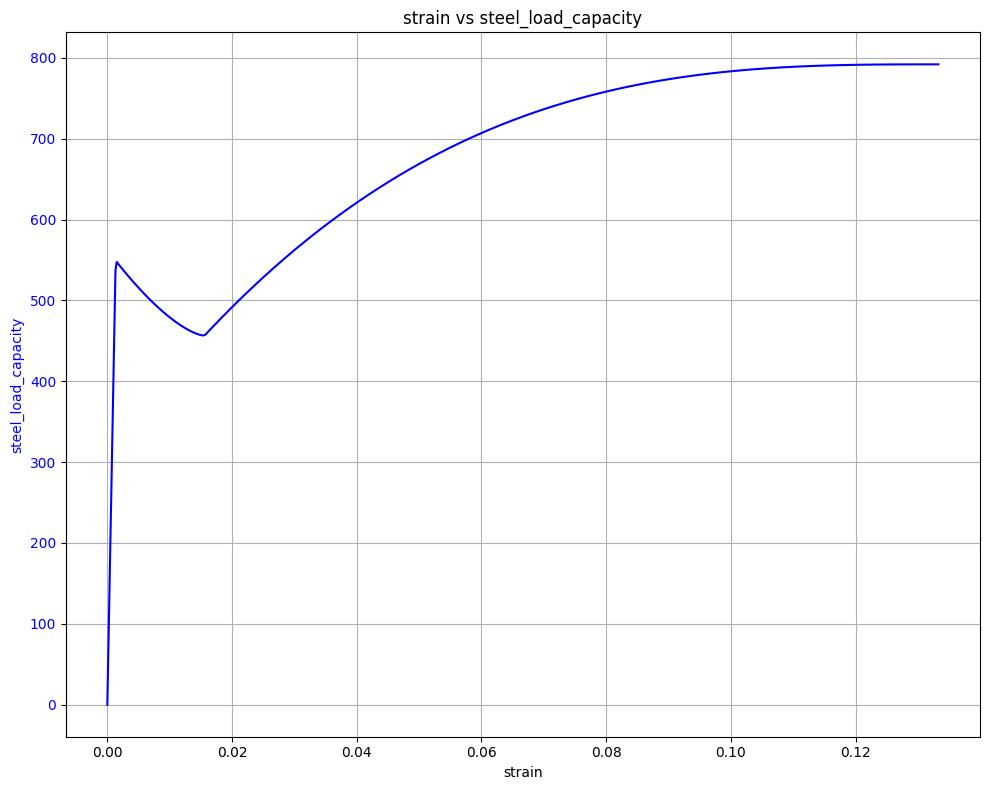

In [37]:
obj.plot_graph("steel_load_capacity")

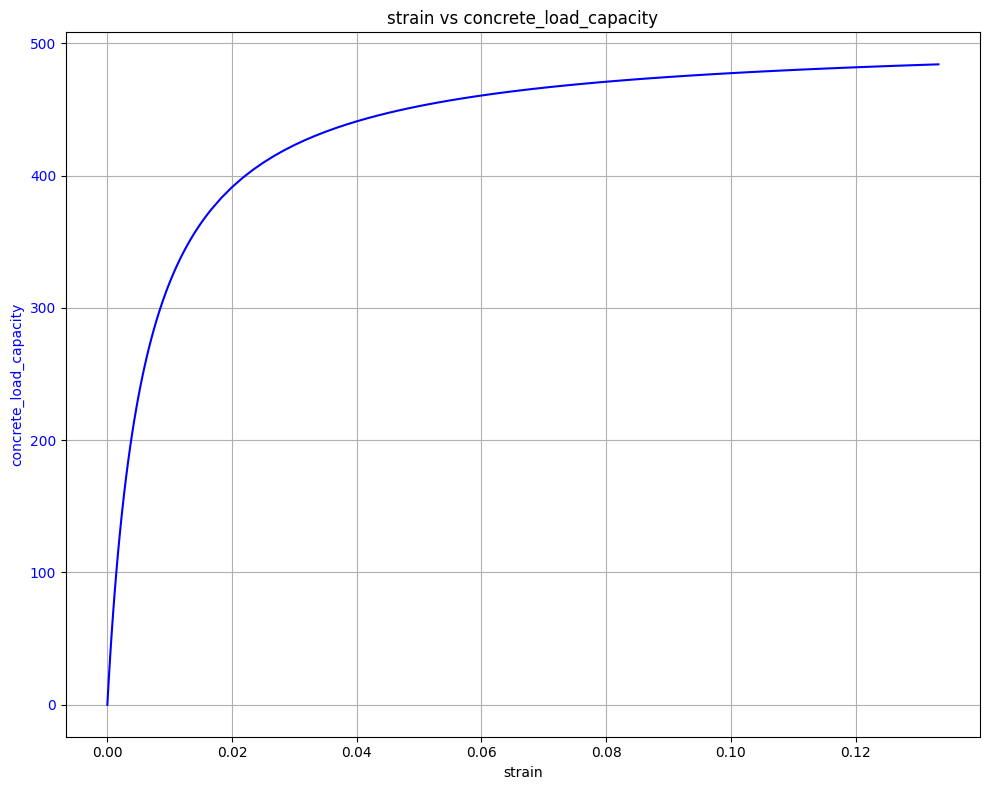

In [38]:
obj.plot_graph("concrete_load_capacity")